Using device: cuda
Input to fc1: torch.Size([64, 1, 1280])
After flattening: torch.Size([64, 1280])
After fc1 and bn1: torch.Size([64, 512])
After fc2 and bn2: torch.Size([64, 256])
After fc3: torch.Size([64, 1])
Input to fc1: torch.Size([64, 1, 1280])
After flattening: torch.Size([64, 1280])
After fc1 and bn1: torch.Size([64, 512])
After fc2 and bn2: torch.Size([64, 256])
After fc3: torch.Size([64, 1])
Input to fc1: torch.Size([64, 1, 1280])
After flattening: torch.Size([64, 1280])
After fc1 and bn1: torch.Size([64, 512])
After fc2 and bn2: torch.Size([64, 256])
After fc3: torch.Size([64, 1])
Input to fc1: torch.Size([64, 1, 1280])
After flattening: torch.Size([64, 1280])
After fc1 and bn1: torch.Size([64, 512])
After fc2 and bn2: torch.Size([64, 256])
After fc3: torch.Size([64, 1])
Input to fc1: torch.Size([64, 1, 1280])
After flattening: torch.Size([64, 1280])
After fc1 and bn1: torch.Size([64, 512])
After fc2 and bn2: torch.Size([64, 256])
After fc3: torch.Size([64, 1])
Input to fc

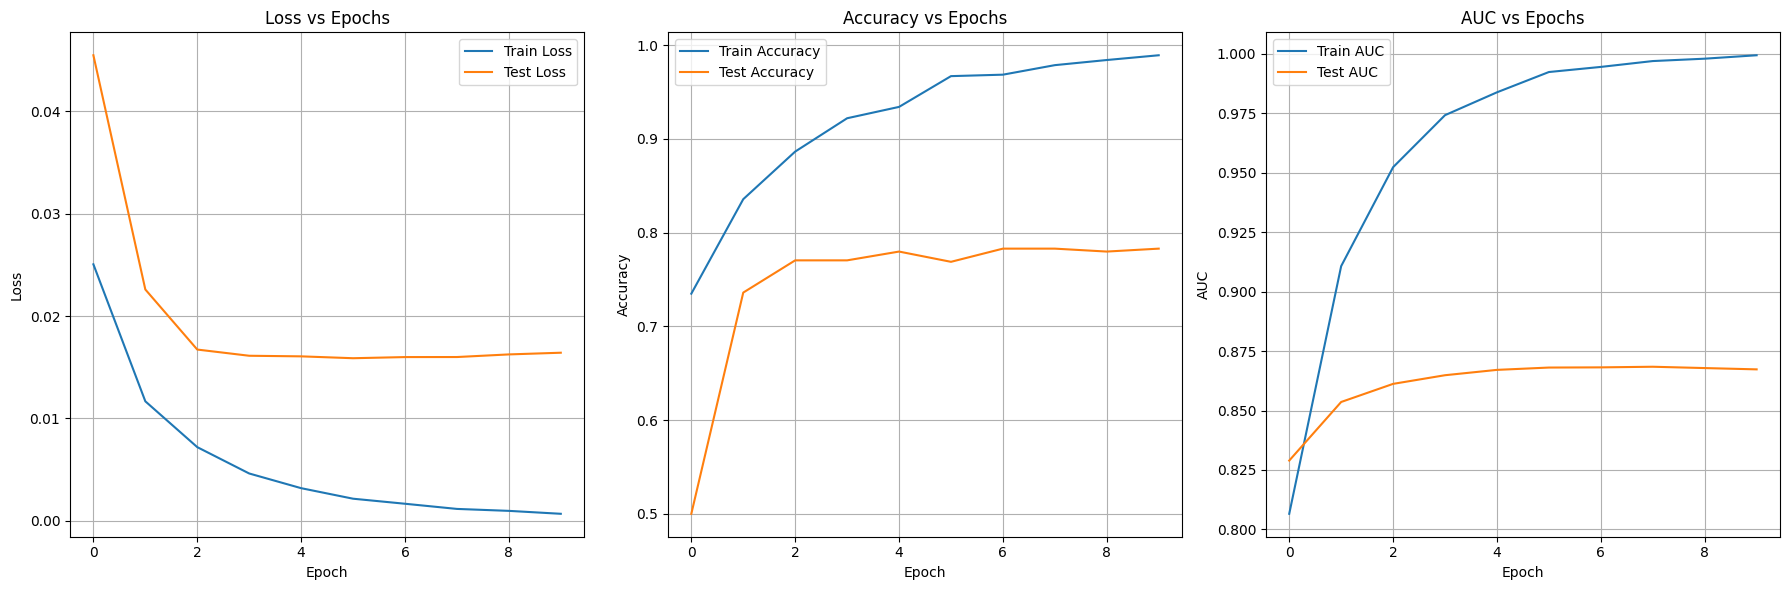

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import efficientnet_b0
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
base_dir = os.path.join('dataset', 'lfw-deepfunneled', 'lfw-deepfunneled')
pairs_train_path = 'pairsDevTrain.txt'
pairs_test_path = 'pairsDevTest.txt'

def normalize_name(name):
    return name.replace(' ', '_')

def load_pairs(pairs_path, base_dir):
    pairs = []
    with open(pairs_path, 'r') as f:
        for line in f.readlines()[1:]:
            parts = line.strip().split()
            if len(parts) == 3:  # Positive pair
                person, img1, img2 = parts
                person = normalize_name(person)
                img1_path = os.path.join(base_dir, person, f"{person}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person, f"{person}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 1))
            elif len(parts) == 4:  # Negative pair
                person1, img1, person2, img2 = parts
                person1, person2 = normalize_name(person1), normalize_name(person2)
                img1_path = os.path.join(base_dir, person1, f"{person1}_{int(img1):04d}.jpg")
                img2_path = os.path.join(base_dir, person2, f"{person2}_{int(img2):04d}.jpg")
                if os.path.exists(img1_path) and os.path.exists(img2_path):
                    pairs.append((img1_path, img2_path, 0))
    return pairs

# Load pairs
train_pairs = load_pairs(pairs_train_path, base_dir)
test_pairs = load_pairs(pairs_test_path, base_dir)
all_pairs = train_pairs + test_pairs

# Data Preprocessing and Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(img_path):
    from PIL import Image
    img = Image.open(img_path).convert("RGB")
    return transform(img)

# EfficientNet backbone
class EfficientNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(EfficientNetFeatureExtractor, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.base_model.classifier = nn.Identity()  # Remove the classification head

    def forward(self, x):
        return self.base_model(x)

efficientnet_model = EfficientNetFeatureExtractor().to(device)

# Precompute Embeddings
def generate_embedding_data(pairs, model):
    data = []
    labels = []
    model.eval()  # Set the feature extractor to evaluation mode
    with torch.no_grad():  # Disable gradient computation for faster inference
        for img1_path, img2_path, label in pairs:
            try:
                img1 = preprocess_image(img1_path).unsqueeze(0)
                img2 = preprocess_image(img2_path).unsqueeze(0)
                emb1 = model(img1.to(device)).cpu().numpy()
                emb2 = model(img2.to(device)).cpu().numpy()
                emb1 = normalize(emb1)
                emb2 = normalize(emb2)
                data.append(np.abs(emb1 - emb2))  # Absolute difference between embeddings
                labels.append(label)
            except Exception as e:
                print(f"Error processing pair: {img1_path}, {img2_path}: {e}")
    return np.array(data), np.array(labels)

# Generate data
X, y = generate_embedding_data(all_pairs, efficientnet_model)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert data into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=64, shuffle=False)

# Siamese Classification Model
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.fc1 = nn.Linear(1280, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        print(f"Input to fc1: {x.shape}")  # Debugging statement
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        print(f"After flattening: {x.shape}")  # Debugging statement
        x = torch.relu(self.bn1(self.fc1(x)))
        print(f"After fc1 and bn1: {x.shape}")  # Debugging statement
        x = torch.relu(self.bn2(self.fc2(x)))
        print(f"After fc2 and bn2: {x.shape}")  # Debugging statement
        x = torch.sigmoid(self.fc3(x))
        print(f"After fc3: {x.shape}")  # Debugging statement
        return x

classification_model = ClassificationModel().to(device)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        bce = nn.BCELoss()(y_pred, y_true)
        pt = torch.exp(-bce)
        loss = self.alpha * ((1 - pt) ** self.gamma) * bce
        return loss

criterion = FocalLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=1e-4)

# Training Loop with Metrics Tracking
def train_model(classifier, train_loader, test_loader, epochs):
    classifier.train()
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_aucs, test_aucs = [], []

    for epoch in range(epochs):
        classifier.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        y_train_true, y_train_pred = [], []

        # Training Phase
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = classifier(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_batch.size(0)
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

            y_train_true.extend(y_batch.cpu().numpy())
            y_train_pred.extend(outputs.cpu().detach().numpy())

        train_losses.append(train_loss / total_train)
        train_accuracies.append(correct_train / total_train)
        train_aucs.append(roc_auc_score(y_train_true, y_train_pred))

        # Validation Phase
        classifier.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        y_test_true, y_test_pred = [], []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                # Forward pass
                outputs = classifier(X_batch)
                loss = criterion(outputs, y_batch)

                test_loss += loss.item() * y_batch.size(0)
                predicted = (outputs > 0.5).float()
                correct_test += (predicted == y_batch).sum().item()
                total_test += y_batch.size(0)

                y_test_true.extend(y_batch.cpu().numpy())
                y_test_pred.extend(outputs.cpu().detach().numpy())

        test_losses.append(test_loss / total_test)
        test_accuracies.append(correct_test / total_test)
        test_aucs.append(roc_auc_score(y_test_true, y_test_pred))

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1] * 100:.2f}%, Train AUC: {train_aucs[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1] * 100:.2f}%, Test AUC: {test_aucs[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies, train_aucs, test_aucs

# Train the model and track metrics
train_losses, test_losses, train_accuracies, test_accuracies, train_aucs, test_aucs = train_model(
    classification_model, train_loader, test_loader, epochs=10
)

# Plotting Metrics
plt.figure(figsize=(18, 6))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid()

# AUC Plot
plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC')
plt.plot(test_aucs, label='Test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC vs Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
